In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import numpy as np
import random
from matplotlib import rcParams

In [4]:
orig_solutions = pd.read_csv('./word_list_data/mystery_words.csv', header=None)[0].to_list()
print(f"{len(orig_solutions)} mystery words")
orig_solutions = list(map(lambda x: x.upper(), orig_solutions))
solutions = list(map(lambda x: list(x), orig_solutions))
orig_herrings = pd.read_csv('./word_list_data/guessable_words.csv', header=None)[0].to_list()
print(f"{len(orig_herrings)} guessable words")
orig_herrings = list(map(lambda x: x.upper(), orig_herrings))
herrings = list(map(lambda x: list(x), orig_herrings))

2315 mystery words
12972 guessable words


In [5]:
letter_map = pd.DataFrame(solutions)
letter_map.columns = ['1', '2', '3', '4', '5']
letter_map

,1,2,3,4,5
0,A,B,A,C,K
1,A,B,A,S,E
2,A,B,A,T,E
3,A,B,B,E,Y
4,A,B,B,O,T
...,...,...,...,...,...
2310,Y,O,U,N,G
2311,Y,O,U,T,H
2312,Z,E,B,R,A
2313,Z,E,S,T,Y


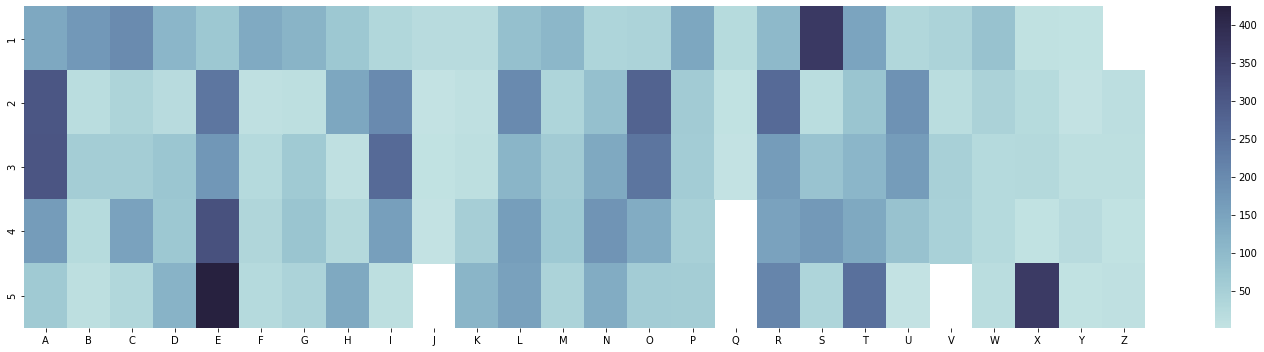

In [6]:
counters = [Counter(letter_map[str(i+1)]) for i in range(len(letter_map.columns))]
fig = plt.figure(figsize=(20, 5))
num_letters = pd.DataFrame(counters)
sns.heatmap(num_letters, xticklabels=list(string.ascii_uppercase), yticklabels=list(range(1,6)), cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.tight_layout()
fig.savefig('./figures/solution_letter_heatmap.png')

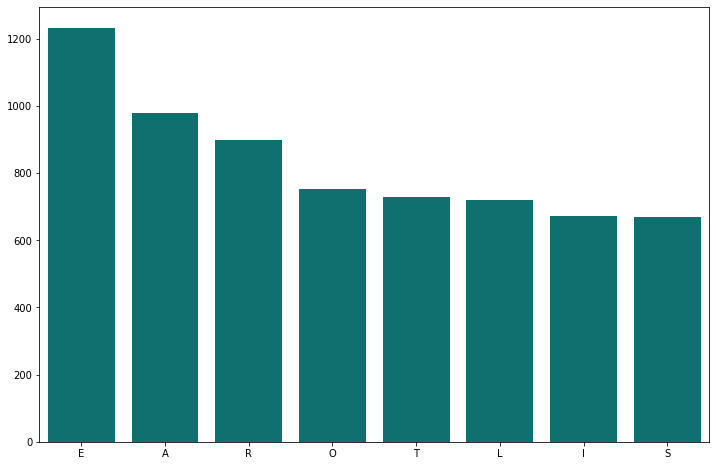

In [7]:
totals = Counter()
for counter in counters:
    totals.update(counter)
top_8_letters = totals.most_common(8)
letters, heights = list(zip(*top_8_letters))
fig = plt.figure(figsize=(12,8))
sns.barplot(x=list(letters), y=list(heights), color='teal')
fig.savefig('./figures/top_eight_letters_by_freq.png')

In [6]:
def process_guess(herring, solution):
    score = []
    for i, letter in enumerate(herring):
        # right letter, right place
        if herring[i] == solution[i]:
            score.append(2)
        # right letter, wrong place
        elif letter in solution:
            score.append(1)
        # wrong letter, wrong place
        else:
            score.append(0)
    return score

def simulate_guess_for_all_solutions(herring, solution_pool):
    heuristics = {'greens': [], 'yellows': [], 'sum': []}
    for solution in solution_pool:
        score = process_guess(herring, solution)
        heuristics['greens'].append(score.count(2))
        heuristics['yellows'].append(score.count(1))
        heuristics['sum'].append(sum(score))
    avg_heuristics = {k: np.mean(v) for k, v in heuristics.items()}
    return avg_heuristics.values()
        
herring_df =  pd.DataFrame(orig_herrings, columns=['herring'])
herring_df['greens'], herring_df['yellows'], herring_df['sum'] = zip(*herring_df['herring'].map(lambda x: simulate_guess_for_all_solutions(x, orig_solutions)))
orig_herring_df = herring_df
orig_herring_df

,herring,greens,yellows,sum
0,AAHED,0.384449,1.180562,1.949460
1,AALII,0.313607,1.310583,1.937797
2,AARGH,0.355508,1.084665,1.795680
3,AARTI,0.327430,1.387041,2.041901
4,ABACA,0.293737,1.193089,1.780562
...,...,...,...,...
12967,ZUZIM,0.172786,0.463067,0.808639
12968,ZYGAL,0.177970,0.819438,1.175378
12969,ZYGON,0.153348,0.699784,1.006479
12970,ZYMES,0.190497,0.856587,1.237581


In [7]:
orig_herring_df.sort_values(by='sum', ascending=False)

,herring,greens,yellows,sum
9558,SAREE,0.680346,1.253132,2.613823
8908,RAREE,0.567603,1.460475,2.595680
9722,SEARE,0.644060,1.289417,2.577538
502,AREAE,0.506263,1.552916,2.565443
514,ARERE,0.501512,1.526566,2.529590
...,...,...,...,...
12967,ZUZIM,0.172786,0.463067,0.808639
4147,FUZZY,0.309719,0.187473,0.806911
8739,PZAZZ,0.205184,0.382289,0.792657
5981,KUDZU,0.130454,0.526566,0.787473


[red]S[/red][red]A[/red][red]R[/red][red]E[/red][red]E[/red] (guess) | MOULT (solution)
[red]N[/red][green]O[/green][red]I[/red][green]L[/green][red]Y[/red] (guess) | MOULT (solution)
[red]C[/red][green]O[/green][green]U[/green][green]L[/green][red]D[/red] (guess) | MOULT (solution)
[green]M[/green][green]O[/green][green]U[/green][green]L[/green][green]T[/green] (guess) | MOULT (solution)
YAY


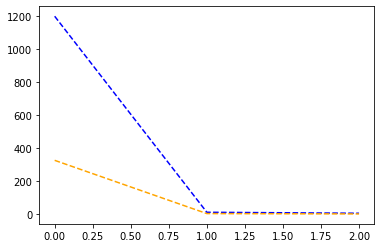

In [8]:
def filter_list(pool, guess, score):
    for i, char in enumerate(guess):
        if score[i] == 2:
            pool = [word for word in pool if word[i] == char]
        elif score[i] == 1:
            pool = [word for word in pool if char in word]
        else:
            pool = [word for word in pool if char not in word]
    return pool

color_map = {2: 'green', 1: 'yellow', 0: 'red'}

def simulate_round(guess, solution, herring_df, solution_pool):
    score = process_guess(guess, solution)
    colored_guess = "".join([f"[{color_map[num]}]{char}[/{color_map[num]}]" for num, char in zip(score, guess)])
    print(f"{colored_guess} (guess) | {solution} (solution)")
    if guess == solution:
        return True
    solution_pool = filter_list(solution_pool, guess, score)
    herring_pool = filter_list(list(herring_df['herring']), guess, score)
    if guess in herring_pool: herring_pool.remove(guess)
    new_herring_df = herring_df.copy()
    new_herring_df = new_herring_df[new_herring_df.herring.isin(herring_pool)]
    # re-run simulation to get new heuristic scoring metrics
    new_herring_df['greens'], new_herring_df['yellows'], new_herring_df['sum'] = zip(*new_herring_df['herring'].map(lambda x: simulate_guess_for_all_solutions(x, solution_pool)))
    return solution_pool, new_herring_df

    
def run_simulation(solution):
    global orig_solutions, orig_herring_df
    solution_pool = orig_solutions
    herring_df = orig_herring_df
    count = 1
    s_pool_size, h_pool_size = [], []
    solved = False
    while not solved:
        # print("--------------")
        # print(f"Guess #{count}")
        guess = herring_df.sort_values(by='sum', ascending=False).iloc[0, 0]
        simu_results = simulate_round(guess, solution, herring_df, solution_pool)
        if simu_results == True:
            solved = True
            print("YAY")
        else:
            solution_pool, herring_df = simu_results
            s_pool_size.append(len(solution_pool))
            h_pool_size.append(len(herring_df))
            # print(f"herring pool size {len(herring_df)}")
            # print(f"solution pool size {len(solution_pool)}")
        count += 1
    fig = plt.figure()
    plt.plot(list(range(count-2)), h_pool_size, color='blue', linestyle='--')
    plt.plot(list(range(count-2)), s_pool_size, color='orange', linestyle='--')
    
solution = random.choice(orig_solutions)
run_simulation(solution)

In [12]:
def compute_avg_pool_size_shrink(herring, herring_pool, solution_pool):
    h_pool_shrink, s_pool_shrink = [], []
    for solution in solution_pool:
        score = process_guess(herring, solution)
        new_solution_pool = filter_list(solution_pool, herring, score)
        new_herring_pool = filter_list(herring_pool, herring, score)
        if herring in new_herring_pool: new_herring_pool.remove(herring)
        h_pool_shrink.append((len(herring_pool) - len(new_herring_pool)) / len(herring_pool))
        s_pool_shrink.append((len(solution_pool) - len(new_solution_pool)) / len(solution_pool))
    return np.mean(h_pool_shrink), np.mean(s_pool_shrink)
      
# compute_avg_pool_size_shrink('ADIEU', orig_herrings, orig_solutions)  

herring_df2 = pd.DataFrame(orig_herrings, columns=['herring'])
herring_df2['herring_pool_shrink'], herring_df2['solution_pool_shrink'] = zip(*herring_df2['herring'].map(lambda x: compute_avg_pool_size_shrink(x, list(herring_df2['herring']), orig_solutions)))
herring_df2.sort_values(by='herring_pool_shrink', ascending=False)